# Image features
In this stage we created features from the images. Unfortunately some of them have been removed. Originally around 9000 of the 32000 posts had an image, but over 1700 images were removed. Images were downloaded using the Reddit API. For images from outside Reddit, we used this library: https://github.com/mikf/gallery-dl

The images were processed in smaller subsets, and this notebook shows the result of running it for a set of about 663 images.

After a brief analysis of what is actually in the images, we created the following features:
- Placeholders (binary feature) whether a post had an image but it was removed and replaced with a placeholder 
- Mean and median, standar deviation and quantiles pixel in grayscale and for each rgb channel and vs channels from hsv color representation
- BagOfVisualWords - created by clustering the feature vectors obtained from the sift descriptor
- Using networks trained on image_net to extract features - last layer before softmax. Additionally, to reduce the final number of features we can use pca, t-sne or fine-tunned model
- Features created on text extracted from images using pytesseract

In [12]:
%matplotlib inline

import glob
import os
from collections import Counter

import cv2
import numpy as np
import pandas as pd
import pytesseract
import tensorflow as tf
import tensorflow_hub as hub
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [13]:
tqdm.pandas()
df = pd.read_csv("../reddit_etap_1_v4.csv")

## New DataFrame with just the post id

In [14]:
df_imgs = df["id"].to_frame()
df_imgs.sample(5)

,id
24765,lbtsp5
13290,l728jc
8676,l70n27
18235,l8hi11
1773,l6yx3i


In [15]:
# IMG_DIR = "images"
IMG_DIR = "images_v2_filtered"
all_img_paths = os.listdir(IMG_DIR)
img_path2id = {
    img_path: os.path.splitext(img_path[1:])[0] for img_path in all_img_paths
}
img_id2path = {i: p for p, i in img_path2id.items()}

# Data analysis on sample of images 

In [16]:
def load_imgs_to_dict(imgs_paths, n_samples=100):
    if n_samples is None:
        n_samples = len(imgs_paths)
        
    all_imgs = {}
    for img_file in tqdm(imgs_paths[:n_samples]):
        img_id = img_path2id[img_file]
        img = cv2.imread(os.path.join(IMG_DIR, img_file))
        all_imgs[img_id] = img
    return all_imgs

100%|██████████| 100/100 [00:03<00:00, 31.91it/s]


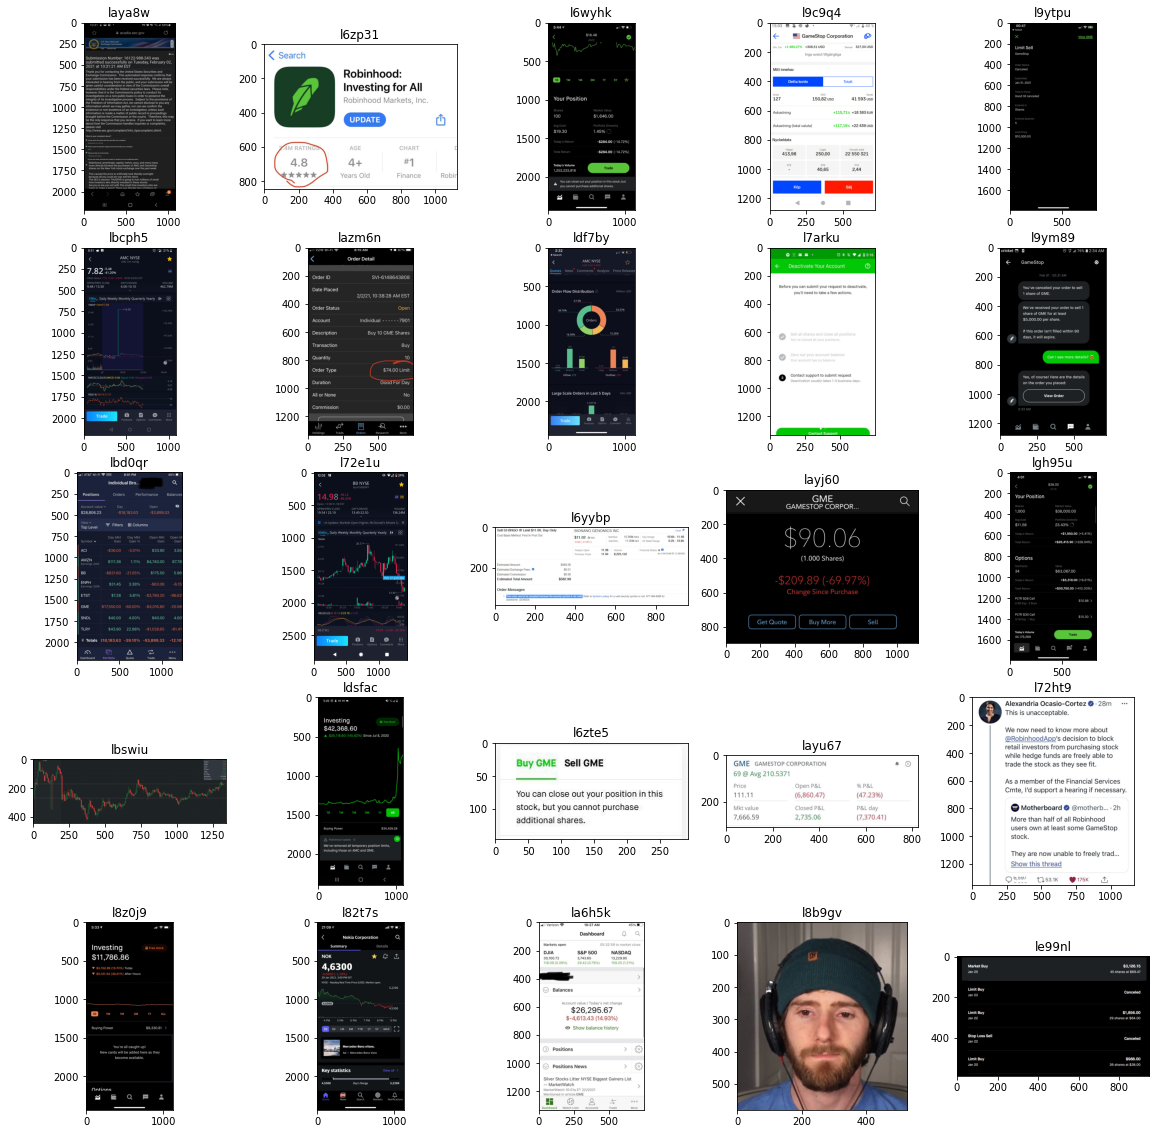

In [17]:
all_imgs = load_imgs_to_dict(all_img_paths)

# helper function for plotting a sample of images
def plot_sample_of_images_from_dict(imgs, n_rows, n_cols=None):
    if n_cols is None:
        n_cols = n_rows
    fig = plt.figure(figsize=(20, 20))
    for i, (img_id, img) in enumerate(list(imgs.items())[: n_rows * n_cols]):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(img_id)

plot_sample_of_images_from_dict(all_imgs, 5)

## FEATURE - placeholder images
Some images were deleted and they have just a placeholder. Those images have to be marked and deleted.
There were no placeholders in this subset of 663 images, but there were over 1,700 of them in total

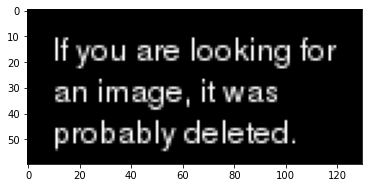

In [18]:
placeholder_img = cv2.imread('placeholder.png')
plt.imshow(placeholder_img)

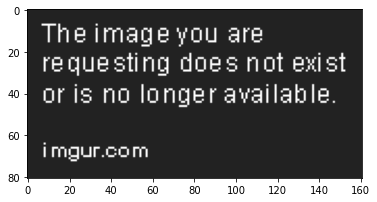

In [19]:
placeholder_img2 = cv2.imread('placeholder2.png')
plt.imshow(placeholder_img2)

In [20]:
placeholder_imgs_ids = []
for img_file in tqdm(all_img_paths):
    img_id = img_path2id[img_file]
    img = cv2.imread(os.path.join(IMG_DIR, img_file))
    if img is None:
        print(img_file)
    if img.shape == placeholder_img.shape and (img == placeholder_img).all():
        placeholder_imgs_ids.append(img_id)
    elif img.shape == placeholder_img2.shape and (img == placeholder_img2).all():
        placeholder_imgs_ids.append(img_id)
print(f'Number of placeholder images: {len(placeholder_imgs_ids)}')

100%|██████████| 663/663 [00:16<00:00, 40.57it/s]

Number of placeholder images: 0


## New feature: placehoder_img - does this post have a placeholder image

In [21]:
all_img_ids = [img_path2id[p] for p in all_img_paths]
df_imgs['img_has_ph'] = np.nan
df_imgs.loc[df_imgs['id'].isin(all_img_ids), 'img_has_ph'] = 0
df_imgs.loc[df_imgs['id'].isin(placeholder_imgs_ids), 'img_has_ph'] = 1
df_imgs['img_has_ph'].sample(10)

8009    NaN
25621   NaN
23394   NaN
6108    NaN
12853   NaN
30315   NaN
5157    NaN
30216   NaN
15336   NaN
30485   NaN
Name: img_has_ph, dtype: float64

## Show images without placeholders

100%|██████████| 100/100 [00:02<00:00, 36.94it/s]


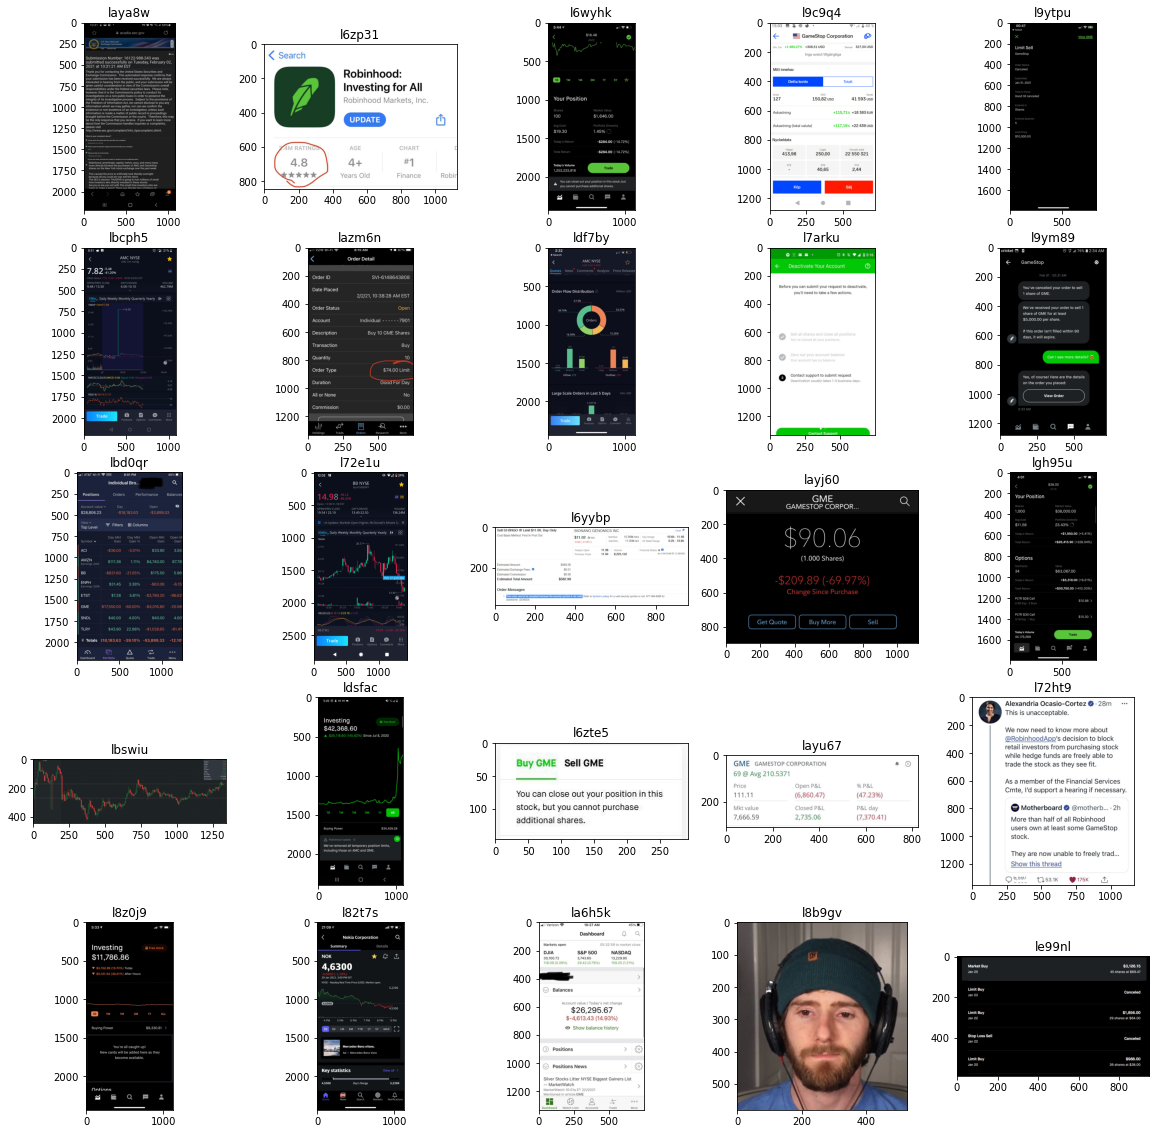

In [22]:
all_img_paths = [im for im in all_img_paths if im[1:].split('.')[0] not in placeholder_imgs_ids]
all_imgs = load_imgs_to_dict(all_img_paths, n_samples=100)
all_img_ids = [img_path2id[img_path] for img_path in all_img_paths]
plot_sample_of_images_from_dict(all_imgs, 5)

## Save dataframe

In [23]:
df_imgs = df_imgs.loc[:, ['id', 'img_has_ph']]
df_imgs.to_csv('df2_has_ph.csv', index=False)

# Basic image features:
Basic features include:
- image width and height
- median, avg, std and percentiles of pixel values (gray and each of the rgb and hsv channels)

The H channel in HSV was omitted because it is an angle on a circle and calculating the statistics in the same way as for other channels is not possible

In [24]:
def calc_basic_stats(img_id):
    # return nan for posts without photo
    if img_id not in all_img_ids:
        return None

    img_path = img_id2path[img_id]
    img = cv2.imread(os.path.join(IMG_DIR, img_path))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # featuers for image in grayscale grayscale
    res_dict = {
        "img_height": img_gray.shape[0],
        "img_width": img_gray.shape[1],
        "img_w2h_ratio": img_gray.shape[1] / img_gray.shape[0],
        "img_median": np.median(img_gray),
        "img_mean": np.mean(img_gray),
        "img_std": np.std(img_gray),
        "img_quantile_25": np.quantile(img, 0.25),
        "img_quantile_75": np.quantile(img, 0.75),
    }

    # features for each channel of BGR image
    for ch, co in enumerate(["_b", "_g", "_r"]):
        res_dict[f"img_median" + co] = np.median(img[:, :, ch])
        res_dict[f"img_mean" + co] = np.mean(img[:, :, ch])
        res_dict[f"img_std" + co] = np.std(img[:, :, ch])
        res_dict[f"img_quantile_25" + co] = np.quantile(img[:, :, ch], 0.25)
        res_dict[f"img_quantile_75" + co] = np.quantile(img[:, :, ch], 0.75)
    
    # features for each channel of HSV image
#     for ch, co in enumerate(["_h", "_s", "_v"]):
#         res_dict[f"img_median" + co] = np.median(img_hsv[:, :, ch])
#         res_dict[f"img_mean" + co] = np.mean(img_hsv[:, :, ch])
#         res_dict[f"img_std" + co] = np.std(img_hsv[:, :, ch])
#         res_dict[f"img_quantile_25" + co] = np.quantile(img_hsv[:, :, ch], 0.25)
#         res_dict[f"img_quantile_75" + co] = np.quantile(img_hsv[:, :, ch], 0.75)

    for ch, co in enumerate(["_s", "_v"]):
        res_dict[f"img_median" + co] = np.median(img_hsv[:, :, ch+1])
        res_dict[f"img_mean" + co] = np.mean(img_hsv[:, :, ch+1])
        res_dict[f"img_std" + co] = np.std(img_hsv[:, :, ch+1])
        res_dict[f"img_quantile_25" + co] = np.quantile(img_hsv[:, :, ch+1], 0.25)
        res_dict[f"img_quantile_75" + co] = np.quantile(img_hsv[:, :, ch+1], 0.75)

    return res_dict

def calc_features_for_each_image(imgs_ids, fun):
    id2features = {}
    for img_id in tqdm(imgs_ids):
        id2features[img_id] = fun(img_id)
    return id2features

In [25]:
res_dict = calc_features_for_each_image(all_img_ids, calc_basic_stats)
df_basic_features = pd.DataFrame.from_dict(res_dict, orient='index')
# df_basic_features.to_csv('df_basic_features.csv')

100%|██████████| 663/663 [02:41<00:00,  4.12it/s]


In [26]:
df_basic_features['id'] = df_basic_features.index
df_imgs = df_imgs.merge(df_basic_features, on='id', how='left')
# df_imgs.to_csv('df_imgs_7736_39f_v1')
df_imgs.sample(5)

,id,img_has_ph,img_height,img_width,img_w2h_ratio,img_median,img_mean,img_std,img_quantile_25,img_quantile_75,...,img_median_s,img_mean_s,img_std_s,img_quantile_25_s,img_quantile_75_s,img_median_v,img_mean_v,img_std_v,img_quantile_25_v,img_quantile_75_v
22568,lazc8e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14243,l72lku,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23979,lbgehz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10561,l71dko,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9277,l70xzm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_imgs.to_csv('df2_ph_and_basic_stats.csv', index=False)

# Feature - Bag of Visual Words
These features were created by clustering the vectors created by the SIFT detector.

In [12]:
class BOVW:
    def __init__(self, dict_size, resize_f):
        self.sift = cv2.SIFT_create()
        self.kmeans = KMeans(n_clusters=dict_size)
        self.scaler = StandardScaler()
        self.dict_size = dict_size
        self.resize_f = resize_f

    def calc_img_des(self, img_gray, resize=None):
        _, des = self.sift.detectAndCompute(img_gray, None)
        return des

    def load_and_compute_descriptors(self, imgs_ids, resize_f=None):
        descriptors = []
        for img_id in tqdm(imgs_ids):
            img_gray = cv2.imread(
                os.path.join(IMG_DIR, img_id2path[img_id]), cv2.IMREAD_GRAYSCALE
            )
            if resize_f is not None:
                img_gray = cv2.resize(
                    img_gray, None, fx=self.resize_f, fy=self.resize_f
                )
            des = self.calc_img_des(img_gray)
            descriptors.append(des)
        return descriptors

    def convert_preds_to_vector(self, preds):
        cnt = Counter(preds)
        return [cnt[i] for i in range(self.dict_size)]

    def fit(self, descriptors):
        samples = np.concatenate(descriptors)
        samples = self.scaler.fit_transform(samples)
        self.kmeans.fit(samples)

    def transform(self, descriptors):
        preds = [self.kmeans.predict(self.scaler.transform(des)) for des in descriptors]
        return [self.convert_preds_to_vector(pred) for pred in preds]

    def fit_transform(descriptors):
        self.fit(descriptors)
        return self.transform(descriptors)

    def load_and_transform(self, imgs_ids):
        id2vec = {}
        for img_id in tqdm(imgs_ids):
            img_gray = cv2.imread(
                os.path.join(IMG_DIR, img_id2path[img_id]), cv2.IMREAD_GRAYSCALE
            )
            if self.resize_f is not None:
                img_gray = cv2.resize(
                    img_gray, None, fx=self.resize_f, fy=self.resize_f
                )
            des = self.calc_img_des(img_gray)
            id2vec[img_id] = self.transform([des])
        return id2vec

    def get_visual_words(self):
        return self.kmeans.cluster_centers_

## Test BOVW representation on sample of images

In [13]:
# Loading previously created features from a csv file
df_imgs = pd.read_csv('df_has_ph.csv')
all_img_ids = df_imgs.loc[df_imgs['img_has_ph'] == 0]['id']
all_imgs_paths = [img_id2path[img_id] for img_id in all_img_ids]
img_path2id = {
    img_path: os.path.splitext(img_path[1:])[0] for img_path in all_img_paths
}
img_id2path = {i: p for p, i in img_path2id.items()}

## Create and train bovw object

In [15]:
bovw = BOVW(20, resize_f=0.5)
descriptors = bovw.load_and_compute_descriptors(all_img_ids[:50])

100%|██████████| 50/50 [00:21<00:00,  2.36it/s]


In [16]:
# fit kmeans on calculated descriptors
bovw.fit(descriptors)

## Use trained BOVW to calculate features for each image

In [21]:
data = bovw.load_and_transform(all_img_ids[:70])

100%|██████████| 70/70 [00:14<00:00,  4.71it/s]


In [22]:
df_bovw = pd.DataFrame.from_dict(data, orient='index', columns=['bovw'])
df_bovw = pd.DataFrame(df_bovw['bovw'].to_list(), index=df_bovw.index)
df_bovw.columns = [f'bovw{i}' for i in range(bovw.dict_size)]
df_bovw.sample(5)

,bovw0,bovw1,bovw2,bovw3,bovw4,bovw5,bovw6,bovw7,bovw8,bovw9,bovw10,bovw11,bovw12,bovw13,bovw14,bovw15,bovw16,bovw17,bovw18,bovw19
l6wu30,90,71,115,59,333,210,104,59,142,51,18,61,78,86,100,19,70,23,289,105
l6wv07,77,60,44,47,7,10,4,0,54,29,14,3,56,0,5,15,4,3,2,5
l6pzvr,0,0,9,0,59,44,34,13,0,0,0,8,0,16,29,0,31,0,37,29
l6uas9,105,77,58,107,11,16,0,3,108,98,12,5,166,2,2,22,0,13,2,10
l6wu3b,50,48,33,61,35,41,18,30,68,38,15,29,40,78,26,31,22,64,29,36


# Data normalization

In [23]:
df_bovw_norm = df_bovw.div(df_bovw.sum(axis=1), axis=0).round(2)
df_bovw_norm[-10:]

,bovw0,bovw1,bovw2,bovw3,bovw4,bovw5,bovw6,bovw7,bovw8,bovw9,bovw10,bovw11,bovw12,bovw13,bovw14,bovw15,bovw16,bovw17,bovw18,bovw19
l6wukz,0.12,0.09,0.18,0.11,0.08,0.02,0.01,0.00,0.08,0.05,0.01,0.01,0.11,0.00,0.04,0.01,0.00,0.04,0.03,0.01
l6wuuy,0.08,0.05,0.04,0.10,0.04,0.01,0.01,0.00,0.15,0.04,0.03,0.01,0.10,0.02,0.00,0.04,0.01,0.25,0.00,0.01
l6wuwf,0.00,0.00,0.27,0.00,0.43,0.18,0.02,0.00,0.00,0.00,0.00,0.02,0.00,0.01,0.02,0.00,0.02,0.00,0.02,0.01
l6wuxi,0.06,0.05,0.05,0.04,0.08,0.07,0.09,0.04,0.03,0.02,0.02,0.02,0.03,0.02,0.05,0.02,0.06,0.01,0.16,0.08
l6wuz2,0.00,0.00,0.02,0.02,0.06,0.08,0.17,0.07,0.00,0.02,0.00,0.05,0.01,0.06,0.09,0.01,0.14,0.01,0.10,0.09
l6wuz0,0.02,0.02,0.06,0.04,0.12,0.10,0.03,0.02,0.03,0.01,0.02,0.04,0.01,0.11,0.05,0.01,0.03,0.18,0.05,0.06
l6wuzo,0.00,0.00,0.03,0.01,0.14,0.12,0.12,0.05,0.00,0.00,0.00,0.03,0.00,0.03,0.05,0.00,0.08,0.00,0.21,0.13
l6wuzp,0.07,0.06,0.06,0.11,0.03,0.02,0.01,0.00,0.27,0.03,0.02,0.06,0.05,0.02,0.01,0.04,0.00,0.11,0.01,0.02
l6wv07,0.18,0.14,0.10,0.11,0.02,0.02,0.01,0.00,0.12,0.07,0.03,0.01,0.13,0.00,0.01,0.03,0.01,0.01,0.00,0.01
l6wv1b,0.13,0.09,0.11,0.15,0.01,0.00,0.00,0.00,0.09,0.10,0.02,0.00,0.22,0.00,0.00,0.02,0.00,0.01,0.02,0.01


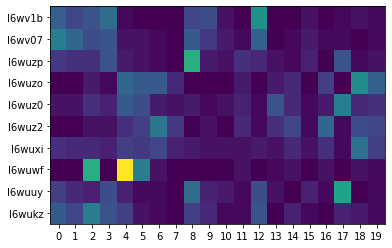

In [24]:
n_rows = 10
plt.pcolor(df_bovw_norm[-n_rows:])
plt.yticks(
    np.arange(0.5, len(df_bovw_norm[-n_rows:].index), 1),
    df_bovw_norm[-n_rows:].index,
)
plt.xticks(
    np.arange(0.5, len(df_bovw_norm[-n_rows:].columns), 1),
    [col[4:] for col in df_bovw_norm[-n_rows:].columns],
)
plt.xlabel
plt.show()

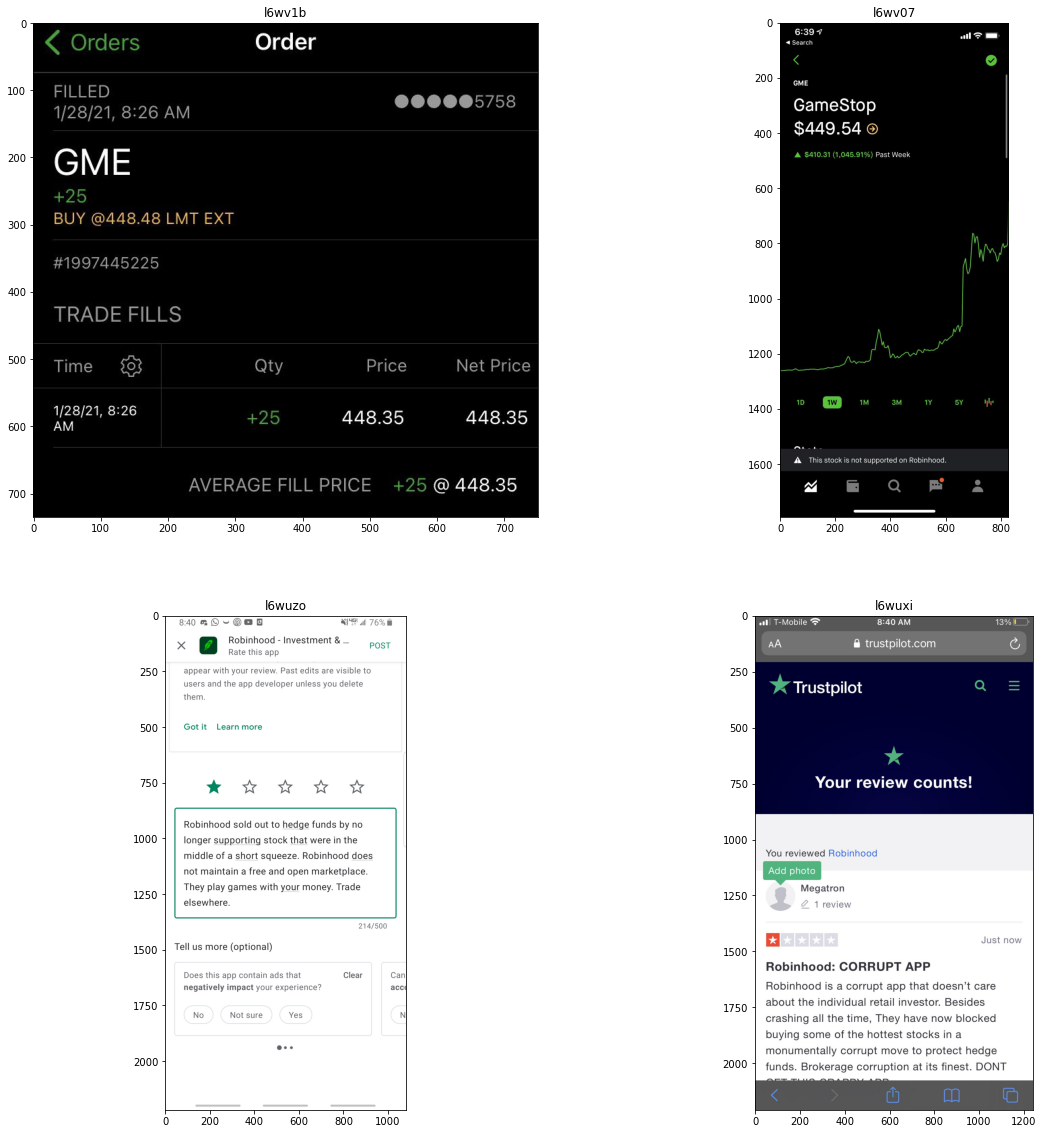

In [27]:
sample_imgs_dict = {

    img_id: cv2.imread(f"{IMG_DIR}/-{img_id}.png")
    for img_id in ["l6wv1b", "l6wv07", "l6wuzo", "l6wuxi"]
}

plot_sample_of_images_from_dict(sample_imgs_dict, 2)

# Extracting features from pretrained models
Here, we have used off-the-shelf models trained on the Imagenet dataset, whose intermediate layers can be thought of as feature extractors. Model is downloaded from tensorflow_hub.

In [ ]:
def decode_img(img, img_height, img_width):
    img = tf.image.decode_png(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img, img_height, img_width)
    return img

def configure_for_performance(ds, batch_size):
    ds = ds.cache()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def preprocess_ds(ds, img_height, img_width, batch_size = 256):
#     process_path = process_path_size(img_height, img_width)
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = configure_for_performance(ds, batch_size)
    return ds

def get_feature_vector(model, ds, file_names, features, batch_size, name=""):
    feature_vector = pd.DataFrame(columns=[f"{name}_{f}" for f in range(features)],
                                  index=file_names)
    for i, image_batch in enumerate(iter(ds)):
        print(f"{i+1}/{len(ds)}", end="\r")
        feature_vector.iloc[i*batch_size:(i+1)*batch_size] = model(image_batch)
    return feature_vector

**Mobilenet_v1**

In [ ]:
ds = tf.data.Dataset.list_files("images_v2_filtered/*", shuffle=False)
samples_len = len(ds)
file_names = [str(f.numpy()).split(".")[0].split("-")[-1] for f in ds.take(-1)]

In [ ]:
img_height, img_width, features = 128, 128, 256
model = hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/mobilenet_v1_025_128/feature_vector/4"
)
model.build([None, img_height, img_width, 3])

In [ ]:
ds = preprocess_ds(ds, img_height, img_width, batch_size = 256)
feature_vector = get_feature_vector(model, ds, file_names, features, name="m_v1", batch_size=256)
# feature_vector.to_csv("mobilenet_v1_025_128_feature_vector_4.csv")

# Text from images
Text has been extracted from the images using pytesseract.

In [47]:
df = pd.read_csv("df_bbov_resize-05_trained-on-1000_7736_20_v1.csv", index_col=0)

In [48]:
def preprocess_final(im):
    im= cv2.bilateralFilter(im,5, 55,60)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    _, im = cv2.threshold(im, 240, 255, 1)
    return im

custom_config = r"--oem 3 --psm 11 -c tessedit_char_whitelist= 'ABCDEFGHIJKLMNOPQRSTUVWXYZ '"

|  i ad  melvin  A frontal wedgie. Instead of underpants being up your butt crack, they ride up  Tee UTE  itis not okay to pick your Melvin in public.  by alicenwundrind October 14, 2014 


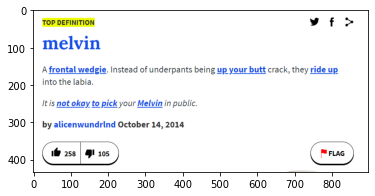

5:03 7  -~  Search  08  °  History  Il History  Orders  Dividends  Rewa  January 2021  Deposit from Regular Checking  +$5,000.00  Deposit from Regular Checking  +$10,000.00  Deposit from Regular Checking  +$5,000.00 


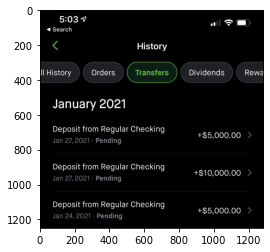

6:06  08  5G @  Investing  $48,463.62  Past Week  Buying Power  $33,331.44  The markets are experiencing significant volatility.  Your investment in $GME involves added risk.  Antinne  4 


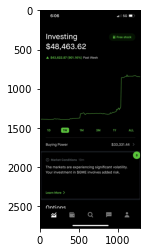

18:03 a0   % 4 044%  €< Q +r/wallstreetbets  —  _  we  a  News  e &  = 


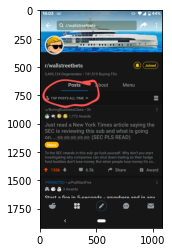

<  GME  Gamestop  $318.01  Today  After-Hours  1D  Position  1.003168  $319.02  $318.99  100%  Today's Volume  91,691,171  24 


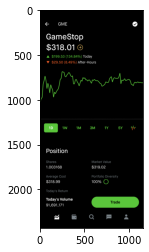

1:30  ar  GME  oO  1  TTA TT Tete Fl  ih  5Y  | 1 | 1W 1M x  wf  Position  Shares  Market Value  111.969183  SCV AsV ACRtels)  Average Cost  Portfolio Diversity  $309.65  100% ©)  Today's Return  +$2,525.56 (+7.14%)  Total Return  +$3,202.45 (+9.24%)  Recurring Investments  Invest on a daily, weekly, biweekly, or monthly  Today's Volume  90,747,959  4  =  oe  r  A 


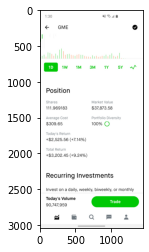

NOK  100  $0.59  $35,750.00>  01/20/2023  +$2.98  +$29,829.73 (503.86%)  melee}  NOK  20  $0.91  Tom sieLONOLObs  04/16/2021  a Pala  +$4,046.73 (223.17%)  5.00 C  NOK  a)  $1.43  RL ES] SYR  01/20/2023  +$1.89  +$8,511.73 (131.95%)  7.00 C  ine  ne  io1078) 


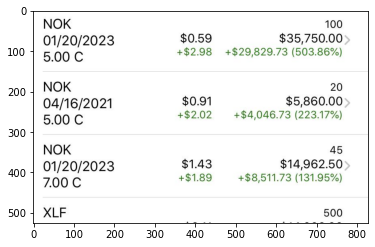

4:53 7  08  -~  °  a  Traditional IRA -’:  Portfolio  Net Account Value  $19,762.11  Day's Gain  Total Gain  Cash  $56.88  Symbol  Last  Day's  Total  Gain $  Gain $  16.56  6.50  5.50  19.90  16.90  22.02  1.71  -—_—  —  -—  -——  vO  —  Watch Lists  Trade  Markets  Menu 


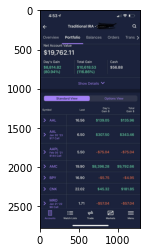

GET YOUR ASS  By  ~ TO MARS! 


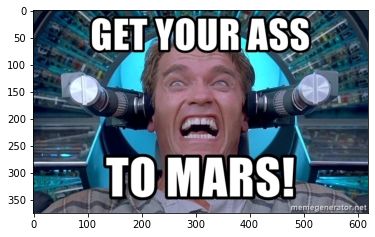

Reddit sll >  6:18 PM  4077.e@  Tweet  Hannah Murphy @  BREAKING: Discord tells me they've  shut down the WallStreetBets server  (their equivalent of the Reddit forum)  "for continuing to allow hateful and  discriminatory content after  repeated warnings"  Says this was not "due to financial  fraud related to GameStop or other  stocks"  10  10  29 


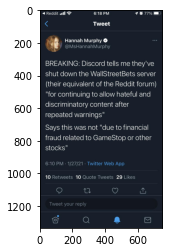

In [50]:
df_text = pd.DataFrame(columns=["image_text"], index=df.index)
# for file_name in tqdm(df.index[:10]):
for file_name in df.index[:10]:
    img = np.array(Image.open(f"images/-{file_name}.png"))
    img_proc = preprocess_final(img)
    img_text = pytesseract.image_to_string(
        img_proc, lang="eng", config=custom_config
    ).replace("\n", " ")

    print(img_text)
    plt.imshow(img)
    plt.show()

#     df_text.loc[len(df)] = (file_name.split(".")[0], img_text)
# df_text.to_csv("df_text_image.csv")

## Features from the extracted texts

In [ ]:
import string
import re
from collections import Counter 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from urllib.parse import urlparse

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy 
import en_core_web_sm

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [ ]:
with open('tesseract_image_text.csv', 'r') as f:
    lines = f.readlines()

In [ ]:
id2text = {l.split(',')[0]: ' '.join(l.split(',')[1:]) for l in lines}
df = pd.DataFrame.from_dict(id2text, orient='index', columns=['img_txt'])

In [ ]:
def preprocess_text(txt, join=True):
    doc = nlp(txt)
    txt_no_punctuation = [t for t in doc if t.text not in string.punctuation]
    txt_no_stopwords = [t for t in txt_no_punctuation if not t.is_stop]
    txt_lemmatized = [t.lemma_ for t in txt_no_stopwords]
    if join:
        txt_lowered = ' '.join([t.lower() for t in txt_lemmatized])
    else:
        txt_lowered = [t.lower() for t in txt_lemmatized]
    return txt_lowered

In [ ]:
tqdm.pandas()
df['preprocessed_img_txt'] = df.img_txt.progress_apply(preprocess_text)

In [ ]:
sid = SentimentIntensityAnalyzer()

# https://github.com/cjhutto/vaderSentiment
def vader_sentiment(text: str):
    d = sid.polarity_scores(text)
    return d['pos'], d['neu'], d['neg'], d['compound']


def num_words(txt):
    return len(txt.split())

    
def calc_percent_of_capital_letters(txt):
    alpha_txt = [l for l in txt if l.isalpha()]
    if not alpha_txt:
        return 0
    else:
        return sum([l.isupper() for l in alpha_txt]) / len(alpha_txt)
    
    
def get_text_features(df: pd.DataFrame):
    df['full_img_txt_length'] = df['img_txt'].apply(lambda x: len(x))
    
    df['num_letters_img_txt'] = df.img_txt.str.len()
    
    df['num_words_img_txt'] = df.preprocessed_img_txt.fillna("").apply(num_words)
    
    df['num_unique_words_img_txt'] = df.preprocessed_img_txt.str.split().apply(lambda x: len(set(x)))

    df['capital_img_txt_perc'] = df.img_txt.fillna('').apply(calc_percent_of_capital_letters)
    
    p = df.img_txt.transform(vader_sentiment).to_list()
    df[['VS_pos','VS_neu','VS_neg','compound']] = pd.DataFrame(p, columns=['VS_pos','VS_neu','VS_neg','compound'])
    df['sentiment'] = df['compound'].apply(lambda c: 'pos' if c>0.1 else 'neg' if c<-0.1 else 'neu')

get_text_features(df)